In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics


In [21]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\seqFISH.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 11529 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped', 'annotation'
    var: 'gene_names'
    uns: 'Spatial_Net', 'annotation_colors'
    obsm: 'SLAT', 'banksy', 'spatial', 'stLVG'

In [22]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\Stereo_seq.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [23]:
embd0 = adata_1.obsm['stLVG']
embd1 = adata_2.obsm['stLVG']
embd2 = adata_1.obsm['SLAT']
embd3 = adata_2.obsm['SLAT']
embd4 = adata_1.obsm['banksy']
embd5 = adata_2.obsm['banksy']

In [6]:
best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2])
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

0.400~0.450         0          0.000%
0.450~0.500         0          0.000%
0.500~0.550         0          0.000%
0.550~0.600         0          0.000%
0.600~0.650         3          0.060%
0.650~0.700        31          0.616%
0.700~0.750        42          0.835%
0.750~0.800       104          2.067%
0.800~0.850       273          5.426%
0.850~0.900       565         11.230%
0.900~0.950      1510         30.014%
0.950~1.000      2503         49.752%


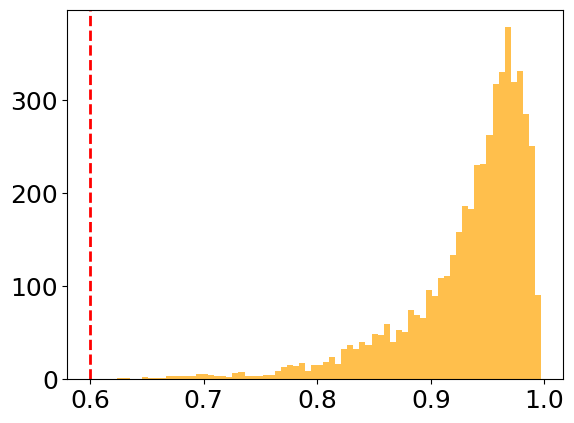

In [8]:
import matplotlib.pyplot as plt
region_statistics(best_match, start=0.4, number_of_interval=12)
# plt.rcParams['xtick.labelsize'] = 14
# plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 18
cut = 0.6
plt.hist(best_match, bins=70, alpha=0.7, color='orange')  # bins可以根据需要调整，alpha设置透明度以便看到线
plt.axvline(x=cut, color='r', linestyle='--', linewidth=2)


plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=14)
plt.title('', fontsize=20)
plt.show()

In [10]:
best_2, index_2, distance_2 = spatial_match([embd2, embd3], adatas=[adata_1, adata_2])
adata3_df = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata4_df = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_2 = np.array([range(index_2.shape[0]), best_2])
best_match_2 = distance_2[:,0]

0.400~0.450        62          1.232%
0.450~0.500       335          6.659%
0.500~0.550       631         12.542%
0.550~0.600       826         16.418%
0.600~0.650       928         18.446%
0.650~0.700       874         17.372%
0.700~0.750       748         14.868%
0.750~0.800       455          9.044%
0.800~0.850       153          3.041%
0.850~0.900        14          0.278%
0.900~0.950         0          0.000%
0.950~1.000         0          0.000%


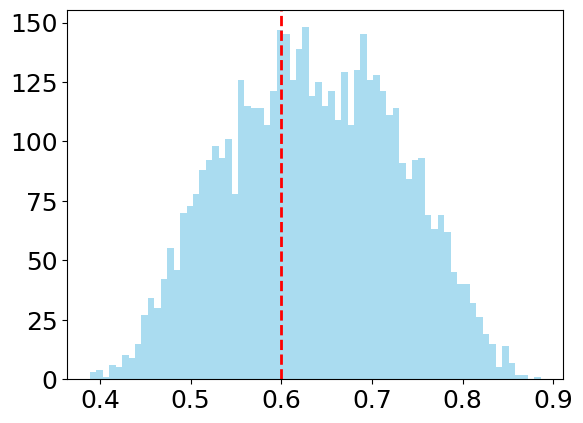

In [11]:
region_statistics(best_match_2, start=0.4, number_of_interval=12)
plt.rcParams['font.size'] = 18
# 设置cut值
cut = 0.6
plt.hist(best_match_2, bins=70, alpha=0.7, color='skyblue')  # bins可以根据需要调整，alpha设置透明度以便看到线

# 在直方图上添加一条垂直线，表示cut值
plt.axvline(x=cut, color='r', linestyle='--', linewidth=2)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
# plt.title('Histogram with Cut-off', fontsize=)
plt.show()

In [24]:
best_3, index_3, distance_3 = spatial_match([embd4, embd5], adatas=[adata_1, adata_2])
adata5_df = pd.DataFrame({'index': range(embd4.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata6_df = pd.DataFrame({'index': range(embd5.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_3 = np.array([range(index_3.shape[0]), best_3])
best_match_3 = distance_3[:,0]

0.400~0.450         0          0.000%
0.450~0.500         0          0.000%
0.500~0.550         1          0.020%
0.550~0.600        47          0.934%
0.600~0.650       154          3.061%
0.650~0.700       296          5.884%
0.700~0.750       548         10.892%
0.750~0.800       725         14.411%
0.800~0.850       786         15.623%
0.850~0.900       857         17.034%
0.900~0.950      1042         20.712%
0.950~1.000       575         11.429%


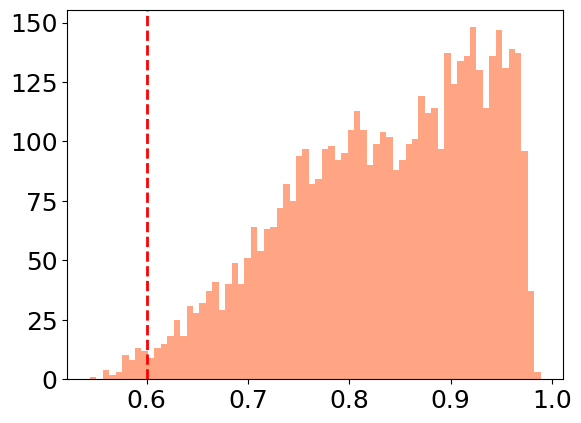

In [31]:
region_statistics(best_match_3, start=0.4, number_of_interval=12)
plt.rcParams['font.size'] = 18
# 设置cut值
cut = 0.6
plt.hist(best_match_3, bins=70, alpha=0.7, color='#FF7F50')  # bins可以根据需要调整，alpha设置透明度以便看到线

# 在直方图上添加一条垂直线，表示cut值
plt.axvline(x=cut, color='r', linestyle='--', linewidth=2)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
# plt.title('Histogram with Cut-off', fontsize=)
plt.show()

In [32]:
adata6_df['target_celltype'] = adata5_df.iloc[matching_3[1,:],:]['celltype'].to_list()
matching_table_3 = adata6_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

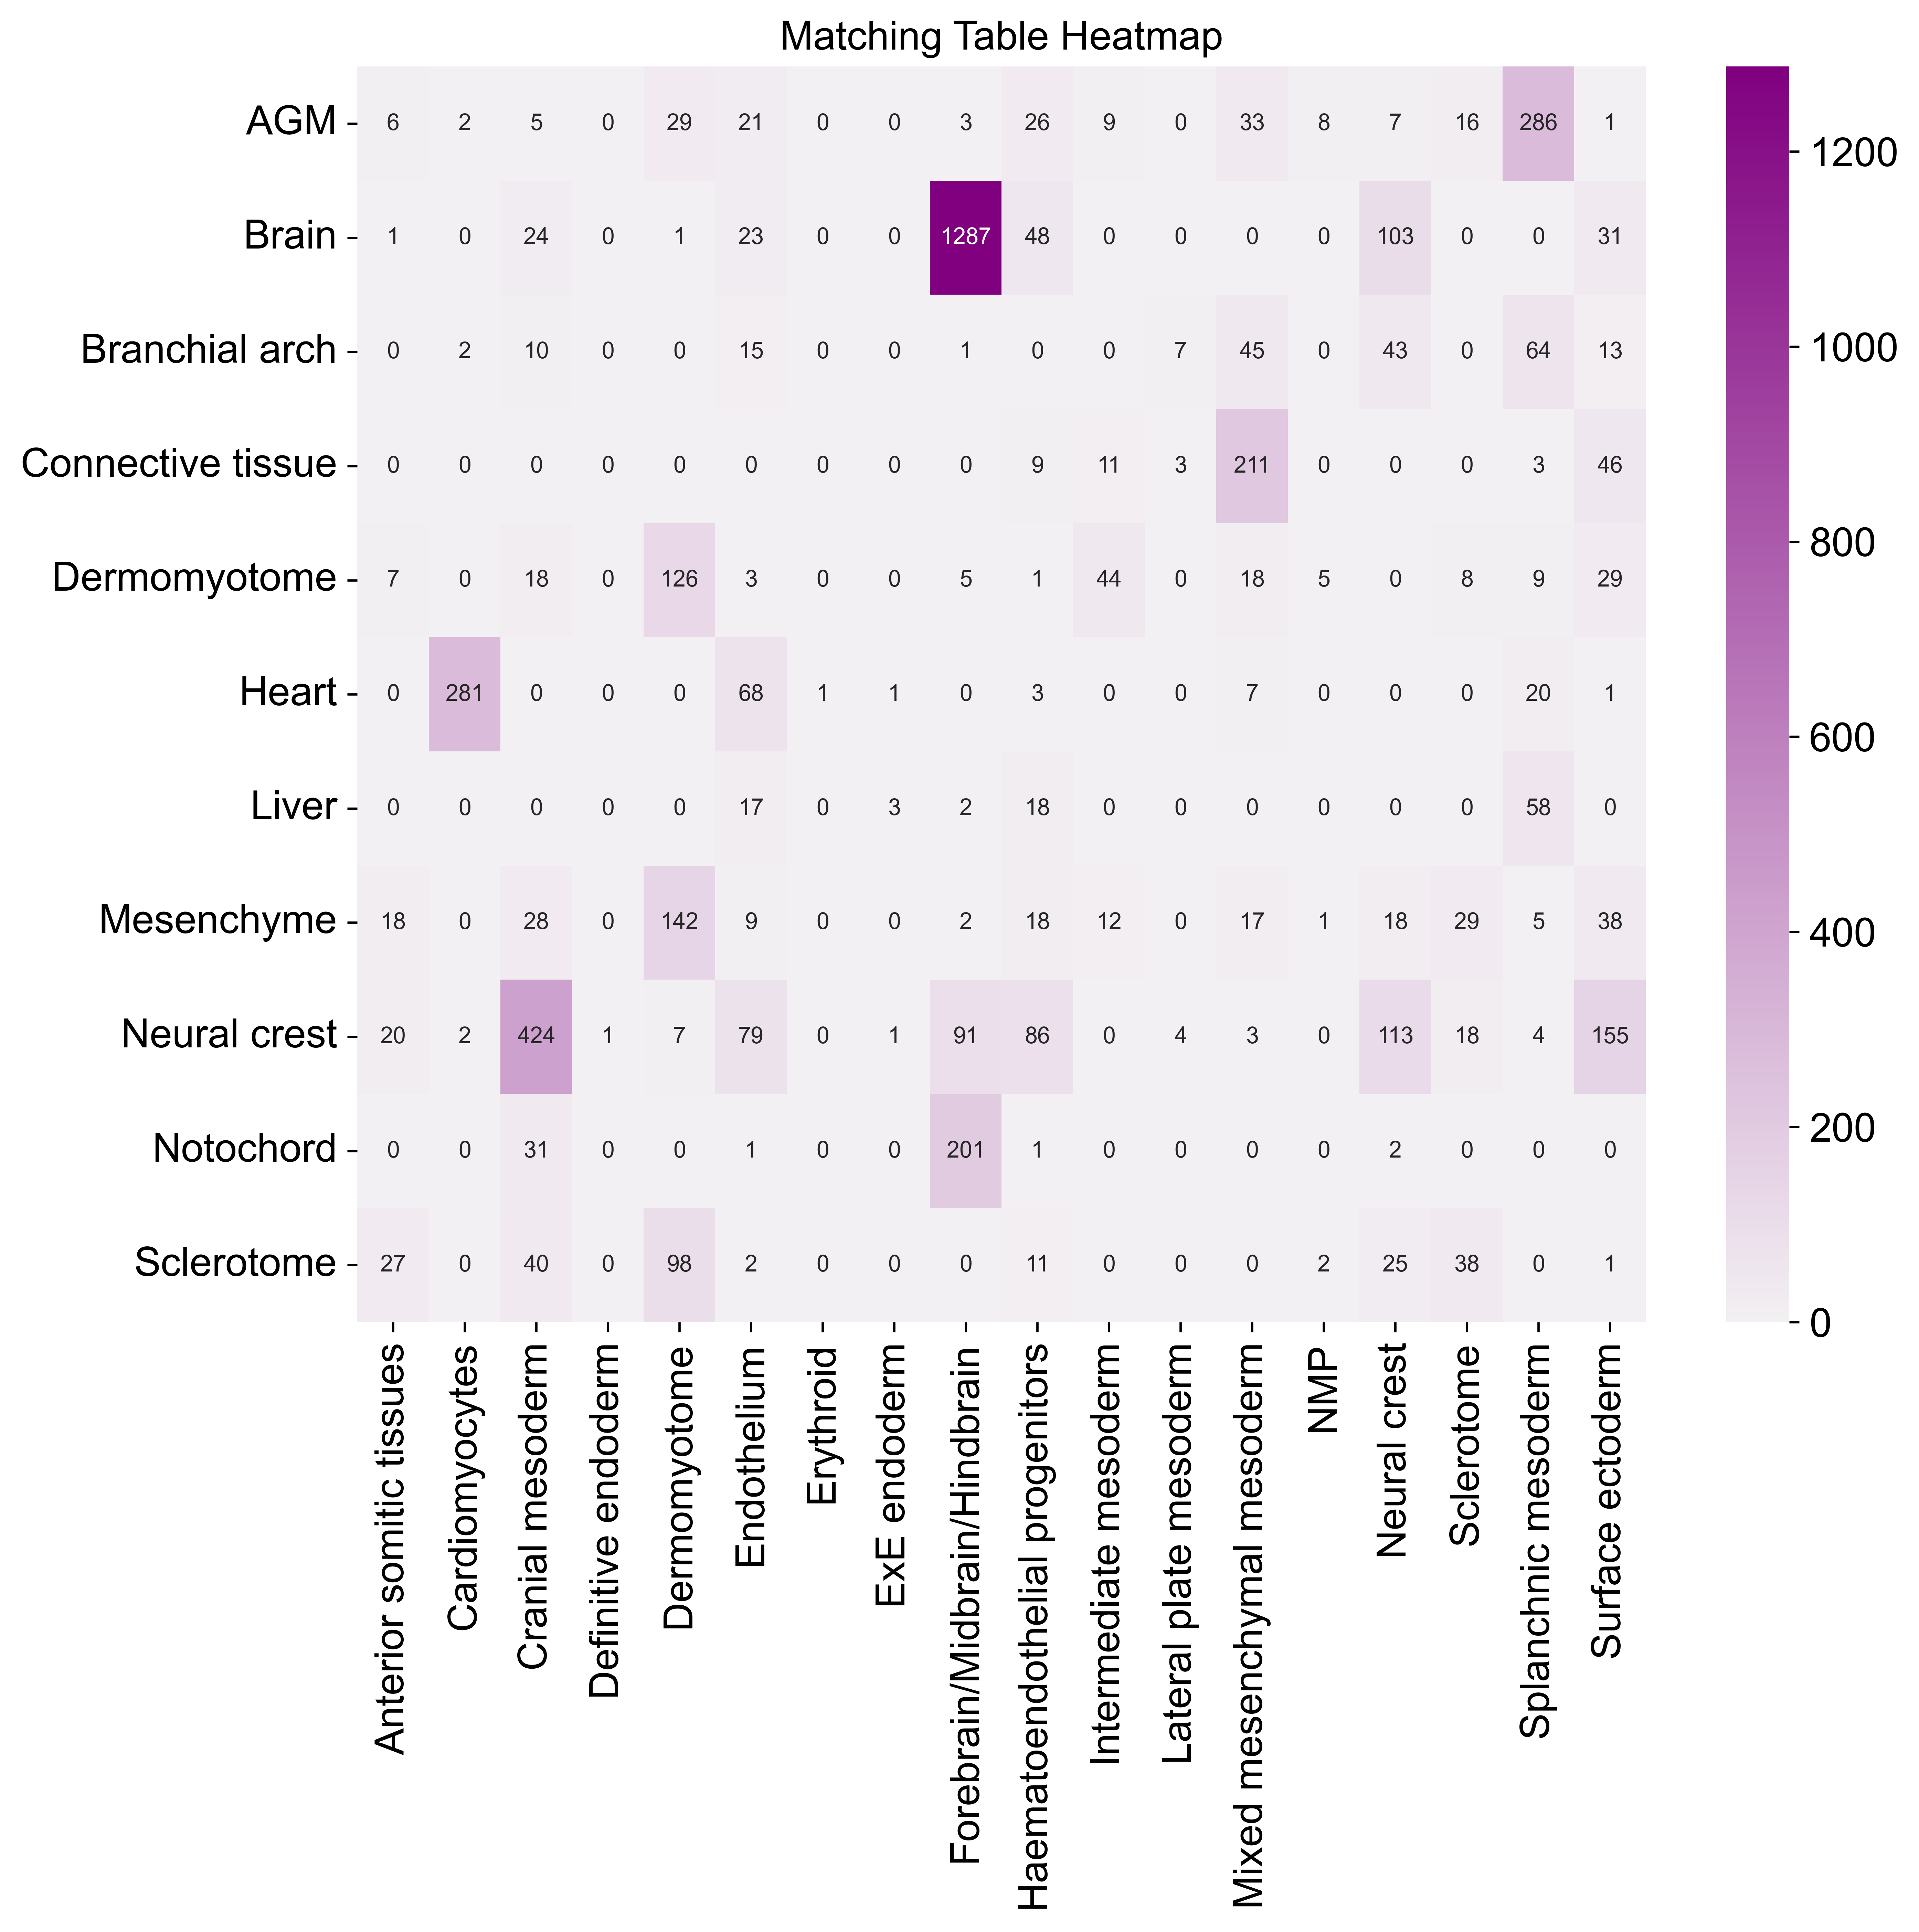

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


sc.set_figure_params(dpi=300, dpi_save=300, transparent=True, facecolor=(1,1,1,1))
custom_cmap = sns.color_palette("light:purple", as_cmap=True)

plt.figure(figsize=(10, 8))  
sns.heatmap(matching_table_3, annot=True, fmt="d", cmap=custom_cmap, annot_kws={'fontsize': 8})  

plt.title('Matching Table Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.show()